In [ ]:
import numpy as np
from skimage import io
from matplotlib import pyplot as plt
import time

In [ ]:
start = time.time()
pgm_path = '/content/color_checker.pgm'
bayer = io.imread(pgm_path).astype(np.uint16)

In [ ]:
# plt.imshow(bayer, cmap = 'gray')

Dead Pixel Concealment (DPC)

In [ ]:
def DPC(bayer, thresh):
  """
  inputs:
    bayer = raw bayer domain image
    thresh = threshold value

  outputs:
    dpc_img = bayer domain image with dead pixels corrected for with mean filter
  """

  padded_bayer = np.pad(bayer, (2,2), 'reflect')
  thresh = thresh * 8

  p1 = padded_bayer[:-4:1, :-4:1] # create 9 different arrays for p0:p8
  p2 = padded_bayer[:-4:1, 2:-2:1]
  p3 = padded_bayer[:-4:1, 4::1]
  p4 = padded_bayer[2:-2:1, :-4:1]
  p0 = padded_bayer[2:-2:1, 2:-2:1]
  p5 = padded_bayer[2:-2:1, 4::1]
  p6 = padded_bayer[4::1, :-4:1]
  p7 = padded_bayer[4::1, 2:-2:1]
  p8 = padded_bayer[4::1, 4::1]

  dv = (p2 + p7 + 1) // 2
  dh = (p4 + p5 + 1) // 2
  ddr = (p1 + p8 + 1) // 2
  ddl = (p3 + p6 + 1) // 2
  min_gradients = np.minimum.reduce((dv, dh, ddr, ddl))

  neighbors = np.array([p1, p2, p3, p4, p5, p6, p7, p8]) # store p1:p8 in a seperate array

  diff = np.abs(neighbors - p0) # store absolute differences between p1:p8 and p0
  condition = diff > thresh # p1:p8 that stores location of all dead pixels
  sum = np.sum(condition, axis = 0) # allows you to check only one 2d array, and test for missed dead pixels with all neighbors

  dpc_img = np.where(sum >= 1, min_gradients, bayer).astype(np.uint16) # if labelled dead by any neighbor, replace with mean

  return dpc_img

In [ ]:
module_start = time.time()
thresh = np.max(bayer) * 0.05
dpc_img = DPC(bayer, thresh)
print("time taken by this module = ", (time.time() - module_start))

# plt.imshow(dpc_img, cmap = 'gray')

time taken by this module =  2.060969591140747


Black Level Compensation (BLC)

In [ ]:
def BLC(dpc_img, offsets):
  """
  inputs:
    dpc_img = bayer domain image after dead pixel concealment
    offsets = dictionary with black level offset values, keys (bl_r, bl_gr, bl_gb, bl_b)

  outputs:
    blc_img = bayer domain image with adjusted black levels
  """

  blc_img = np.empty(dpc_img.shape) # create an empty 2D array of the same size as the dpc_img

  r = dpc_img[::2, ::2] # use array splicing to extract r, gr, gb, and b pixels from the full bayer image
  gr = dpc_img[1::2, ::2]
  gb = dpc_img[::2, 1::2]
  b = dpc_img[1::2, 1::2]

  r = r + offsets['bl_r'] # add offsets to each channel
  gr = gr + offsets['bl_gr']
  gb = gb + offsets['bl_gb']
  b = b + offsets['bl_b']

  blc_img[::2, ::2] = r # return the adjusted values to create a final image
  blc_img[1::2, ::2] = gr
  blc_img[::2, 1::2] = gb
  blc_img[1::2, 1::2] = b

  return np.clip(blc_img, 0, None)

In [ ]:
module_start = time.time()
offsets = {'bl_r':-10, 'bl_gr':-10, 'bl_gb':-10, 'bl_b':-10}
blc_img = BLC(bayer, offsets)
print("time taken by this module = ", (time.time() - module_start))

# plt.imshow(blc_img, cmap = 'gray')

time taken by this module =  0.258800745010376


Lens Shading Correction (LSC)

In [ ]:
def LSC(blc_img, k, offset):
  """
  inputs:
    blc_img = bayer domain image after black level compensation
    k = correction factor to control strength of the correction
    offset = offset in case the final image is too bright

  outputs:
    lsc_img = bayer domain image adjusted for lens shading
  """

  rows, cols = blc_img.shape
  center_x = (cols // 2) + 1 # identify center if the image
  center_y = (rows // 2) + 1
  x, y = np.meshgrid(np.arange(cols), np.arange(rows)) # create an array where each index is the radial distance from the center
  radial_dist = np.sqrt((x - center_x)**2 + (y - center_y)**2)
  radial_dist = np.where(radial_dist <= 1300, 1300, radial_dist) # ensure correction only applies on the outer edges

  lsc_img = (blc_img * (k * radial_dist + 1) - offset).astype(np.uint16) # apply correction

  return lsc_img

In [ ]:
module_start = time.time()
k = 0.0015
offset = 0
lsc_img = LSC(blc_img, k, offset)
print("time taken by this module = ", (time.time() - module_start))

# plt.imshow(lsc_img, cmap = 'gray')

time taken by this module =  0.7805676460266113


In [ ]:
def AAF(lsc_img, k):
  """
  inputs:
    lsc_img = bayer domain image after lens shading correcting
    k = anti-aliasing correction factor to control strenght of anti-aliasing

  outputs:
    aaf_img = bayer domain image after applying anti-aliasing
  """

  filter = np.array([
      [1, 0, 1, 0, 1],
      [0, 0, 0, 0, 0],
      [1, 0, k, 0, 1],
      [0, 0, 0, 0, 0],
      [1, 0, 1, 0, 1]
  ]) / (k+8) # define filter for a weighted average over neighboring pixels

  rows, cols = lsc_img.shape
  aaf_img = np.empty((rows, cols)) # create an empty array the size of the bayer image to apply anti-aliasing in
  padded_img = np.pad(lsc_img, (2,2), 'reflect') # pad image to allow filter to work on image edges

  for i in range(2, rows+2):
    for j in range(2, cols+2):
      aaf_img[i-2, j-2] = np.sum(filter * padded_img[i-2:i+3, j-2:j+3]) # compute the dot product using the filter and neighbor pixels

  return aaf_img

time taken by this module =  180.73793983459473


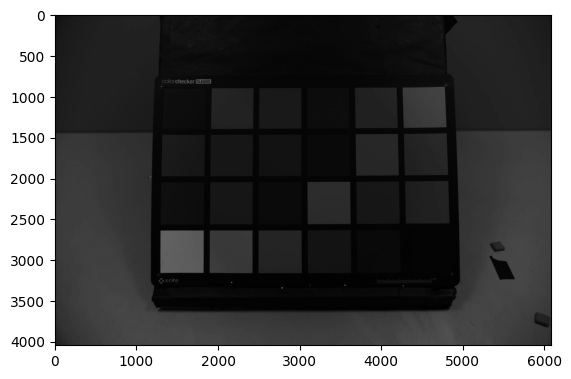

In [ ]:
module_start = time.time()
k = 8
aaf_img = AAF(lsc_img, k)
print("time taken by this module = ", (time.time() - module_start))

plt.imshow(aaf_img, cmap = 'gray')

Anti-Aliasing Noise Filter (AAf)

In [ ]:
def AAF(lsc_img, k):
  """
  inputs:
    lsc_img = bayer domain image after lens shading correcting
    k = anti-aliasing correction factor to control strenght of anti-aliasing

  outputs:
    aaf_img = bayer domain image after applying anti-aliasing
  """

  padded_img = np.pad(lsc_img, (2,2), 'reflect') # pad the image to give corner pixels full set of neighbors

  p1 = padded_img[:-4:1, :-4:1] # create 9 different arrays for p0:p8
  p2 = padded_img[:-4:1, 2:-2:1]
  p3 = padded_img[:-4:1, 4::1]
  p4 = padded_img[2:-2:1, :-4:1]
  p0 = padded_img[2:-2:1, 2:-2:1] * (k**0.5)
  p5 = padded_img[2:-2:1, 4::1]
  p6 = padded_img[4::1, :-4:1]
  p7 = padded_img[4::1, 2:-2:1]
  p8 = padded_img[4::1, 4::1]

  neighbors = np.array([p1, p2, p3, p4, p0, p5, p6, p7, p8]) / ((k + 8)**0.5)
  aaf_img = (np.sum(neighbors, axis = 0)).astype(np.uint16) # apply the filter

  return aaf_img

In [ ]:
module_start = time.time()
k = 64
aaf_img = AAF(lsc_img, k)
print("time taken by this module = ", (time.time() - module_start))

# plt.imshow(aaf_img, cmap = 'gray')

time taken by this module =  2.736480474472046
